# Example of UNET module

In [1]:
import os
import time
import numpy as np
import renom as rm
from tqdm import tqdm
import matplotlib.pyplot as plt

from renom_img.api.segmentation.unet import UNet
from renom_img.api.utility.distributor.distributor import ImageDistributor
from renom_img.api.utility.augmentation import Augmentation
from renom_img.api.utility.augmentation.process import *
from renom_img.api.utility.misc.display import draw_segment
from renom_img.api.utility.evaluate import EvaluatorSegmentation

from renom.cuda import set_cuda_active
from PIL import Image
%matplotlib inline

In [2]:
set_cuda_active(True)

In [3]:
# if not os.path.exists("VOCdevkit/VOC2012"):
#     !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#     !tar xfv VOCtrainval_11-May-2012.tar

In [4]:
class_map = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
             'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
             'dog', 'horse', 'motorbike', 'person', 'potted plant', 
             'sheep', 'sofa', 'train', 'tv/monitor', 'void']

prefix_path = '/mnt/data1/jun/dataset/VOCdevkit/VOC2012/'

In [5]:
train_image_path_list = []
train_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'train.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        train_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        train_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
                                          
valid_image_path_list = []
valid_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'val.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        valid_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        valid_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
        
print("Dataset size")
print("  Train:{}".format(len(train_image_path_list)))
print("  Valid:{}\n".format(len(valid_image_path_list)))
        

Dataset size
  Train:1464
  Valid:1449



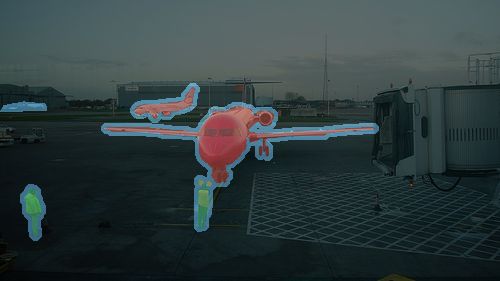

In [6]:
annot = np.array(Image.open(train_annotation_path_list[0]))
draw_segment(train_image_path_list[0], annot, show_background=True)

In [7]:
model = UNet(class_map, imsize=(124, 124), train_whole_network=True)

In [8]:
augmentation = Augmentation([
                Flip(),
                WhiteNoise(),
                ContrastNorm([0.5, 1.0])
            ])

Epoch:000 Avg Train Loss:1.7382 Avg Valid Loss:1.5601: 100%|██████████| 46/46 [01:31<00:00,  1.03it/s]


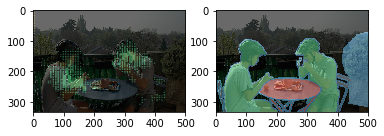

Epoch:001 Avg Train Loss:1.5178 Avg Valid Loss:1.5067: 100%|██████████| 46/46 [01:30<00:00,  1.03it/s]


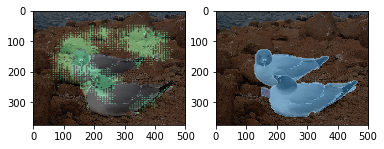

Epoch:002 Avg Train Loss:1.4800 Avg Valid Loss:1.4898: 100%|██████████| 46/46 [01:29<00:00,  1.03it/s]


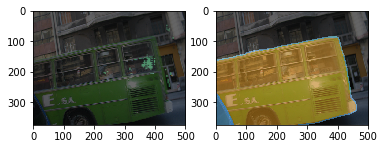

Epoch:003 Avg Train Loss:1.4525 Avg Valid Loss:1.4465: 100%|██████████| 46/46 [01:30<00:00,  1.06it/s]


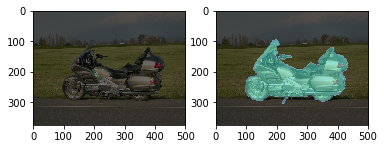

Epoch:004 Avg Train Loss:1.4412 Avg Valid Loss:1.5173: 100%|██████████| 46/46 [01:29<00:00,  1.08it/s]


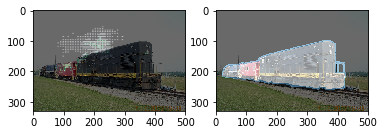

Epoch:005 Avg Train Loss:1.4225 Avg Valid Loss:1.5089: 100%|██████████| 46/46 [01:30<00:00,  1.11it/s]


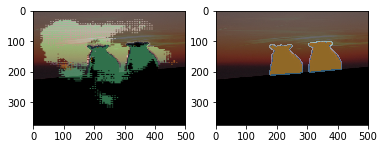

Epoch:006 Train Loss:1.5209:  61%|██████    | 28/46 [00:35<00:21,  1.20s/it]

In [ ]:
def callback(epoch, *args):
    image_id = np.random.randint(len(train_image_path_list))
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(draw_segment(train_image_path_list[image_id], model.predict(train_image_path_list[image_id])))
    fig.add_subplot(1, 2, 2)
    annot = np.array(Image.open(train_annotation_path_list[image_id]))
    plt.imshow(draw_segment(train_image_path_list[image_id], annot))
    plt.show()
    model.save('/mnt/data1/jun/checkpoints/unet/model3_{}.hdf5'.format(epoch))

model.fit(train_img_path_list=train_image_path_list, train_annotation_list=train_annotation_path_list,
          valid_img_path_list=valid_image_path_list, valid_annotation_list=valid_annotation_path_list, 
          batch_size=32, callback_end_epoch=callback, augmentation=augmentation, epoch=200, class_weight=False)

In [ ]:
results = model.predict(valid_image_path_list)

In [ ]:
imsize = (224, 224)
targets = []
for path in valid_annotation_path_list:
    annot = Image.open(path)
    annot.load()
    annot = np.array(annot.resize(imsize))
    for i in range(annot.shape[0]):
        for j in range(annot.shape[1]):
            if annot[i, j] >= len(class_map):
                annot[i, j] = 0
    targets.append(annot)
targets = np.array(targets)            

In [ ]:
evaluator = EvaluatorSegmentation(results, targets)

In [ ]:
print(evaluator.report())